# Advanced Data Analysis Project

## Elon musk quotes and Tesla stock price 

### Research notebook

### Imports 

In [1]:
import json 
import bz2
import csv 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import pandas_datareader as web 
import re, string
import nltk 
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from scipy.stats import ttest_ind
import os
import string
import plotly
import plotly.express as px
import statsmodels.formula.api as smf
import statsmodels.api as sm
import plotly.graph_objects as go


from PIL import Image
from wordcloud import WordCloud

#Downloads
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#!pip install --upgrade pandas
#!pip install --upgrade pandas-datareader
#!pip install --upgrade plotly


<hr style="border:2px solid gray"> </hr>


## Part 1: Loading the dataset

We want to access the Quotebank data present in a Google Drive. To do so, we create two lists, the first one `path_to_file` containing the paths of the files to read and the second one `path_to_out` contains the paths of the new files that we will write. 

In [4]:
path_to_file = [ '/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2', 
                 '/content/drive/MyDrive/Quotebank/quotes-2019.json.bz2',
                 '/content/drive/MyDrive/Quotebank/quotes-2018.json.bz2',
                 '/content/drive/MyDrive/Quotebank/quotes-2017.json.bz2',
                 '/content/drive/MyDrive/Quotebank/quotes-2016.json.bz2',
                 '/content/drive/MyDrive/Quotebank/quotes-2015.json.bz2',
]
path_to_out = ['/content/drive/MyDrive/2020-ElonMusk.json.bz2',
               '/content/drive/MyDrive/2019-ElonMusk.json.bz2',
               '/content/drive/MyDrive/2018-ElonMusk.json.bz2',
               '/content/drive/MyDrive/2017-ElonMusk.json.bz2',
               '/content/drive/MyDrive/2016-ElonMusk.json.bz2',
               '/content/drive/MyDrive/2015-ElonMusk.json.bz2']


We first load and read all the QuoteBank data. Each quote has a speaker, and we are interested in all quotes coming from Elon Musk from 2015 to 2020. So from the QuoteBank data, we apply this first selection : each time a quote's speaker is Elon Musk, we write this quote on a new file. (this cell should only be run once to obtain our data)

In [5]:
#I comment it so we can use the run all cells feature 
#to decomment when we submit 
'''for path_to, path_out in zip(path_to_file,path_to_out):
  with bz2.open(path_to, 'rb') as s_file:
  with bz2.open(path_out, 'wb') as d_file:
      for instance in s_file:
          instance = json.loads(instance) # loading a sample
          if instance['speaker'] == 'Elon Musk':
              d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file
'''

"for path_to, path_out in zip(path_to_file,path_to_out):\n  with bz2.open(path_to, 'rb') as s_file:\n  with bz2.open(path_out, 'wb') as d_file:\n      for instance in s_file:\n          instance = json.loads(instance) # loading a sample\n          if instance['speaker'] == 'Elon Musk':\n              d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file\n"

<hr style="border:2px solid gray"> </hr>


## Part 2 : Data handling 



From Part 1, we obtained 6 json files containing all Elon Musk quotes. The first thing to do now is to create a DataFrame that contains all this data, and we use the same list `path_to_out` that contains the paths of the new files obtained previously. So we read the json files and create `df_musk` DataFrame in which we concatenate all the data from 2015 to 2020.

In [6]:
df_musk = pd.concat((pd.read_json(file, lines = True) for file in path_to_out),ignore_index=True)
df_musk.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2020-03-24-078524,We are grateful for the discussion with @ElonM...,Elon Musk,[Q317521],2020-03-24 05:56:00,2,"[[Elon Musk, 0.5366], [None, 0.4634]]",[https://paloaltoonline.com/news/2020/03/23/wi...,E
1,2020-02-07-002094,A PhD is definitely not required. All that mat...,Elon Musk,[Q317521],2020-02-07 00:00:00,1,"[[Elon Musk, 0.9278], [None, 0.0722]]",[https://www.teslarati.com/tesla-ai-autopilot-...,E
2,2020-03-24-002121,addressing COVID-19 is a group effort. We are ...,Elon Musk,[Q317521],2020-03-24 18:18:25,1,"[[Elon Musk, 0.733], [None, 0.267]]",[https://www.massdevice.com/elon-musk-says-he-...,E
3,2020-03-09-007954,But I'd like to at least be around to see a bu...,Elon Musk,[Q317521],2020-03-09 20:30:24,2,"[[Elon Musk, 0.9132], [None, 0.0868]]",[https://www.cnbc.com/2020/03/09/spacex-plans-...,E
4,2020-03-09-078624,will not cause any impact whatsoever in astron...,Elon Musk,[Q317521],2020-03-09 17:58:09,11,"[[Elon Musk, 0.815], [None, 0.1833], [Gwynne S...",[http://www.breitbart.com/news/elon-musk-dismi...,E


**Some sanity checks**

We have to check that all the quotes we have are from Elon Musk, we remove all duplicates from the data and we can plot the distribution of the quotes he made over time.

In [7]:
other_speaker = len(df_musk[df_musk['speaker'] != 'Elon Musk'])
print ("There are {} quotes with a speaker who isn't Elon Musk".format(other_speaker))

There are 0 quotes with a speaker who isn't Elon Musk


Now we need to check for duplicate rows based on `quotation` column

In [8]:
duplicate = len(df_musk[df_musk.duplicated('quotation')])
print ("There are {} quotes duplicated".format(duplicate))

There are 0 quotes duplicated


Let's look for the distribution of Elon Musk quotes along time. In our DataFrame `df_musk`, we have the column `date` that contains both the date and hour of the quotation, so we create a new column `just_date` in which we conserve only the date. Then, we groupby this new column and count how many quotes have been said this day and finally plot the distribution of these occurences versus time.

Text(0.5, 1.0, 'Number of Elon Musk quotes per day')

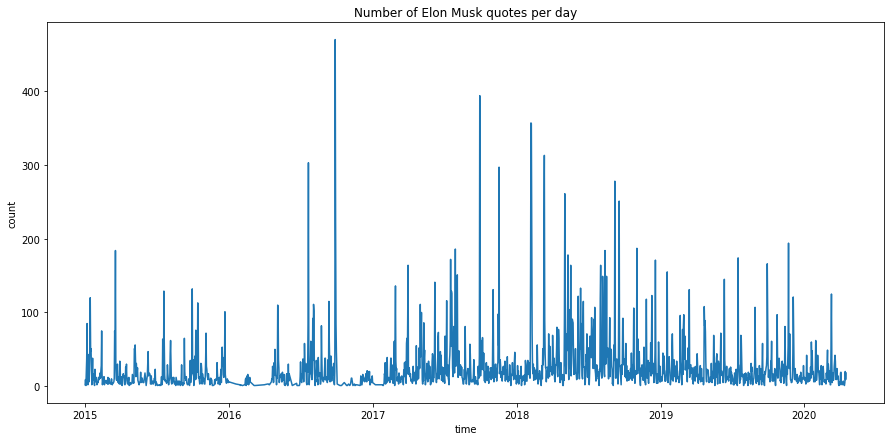

In [9]:
df_musk['just_date'] = df_musk['date'].dt.date
fig,ax = plt.subplots(figsize =(15,7))
df_musk.groupby(by='just_date').count()['quotation'].plot(ax=ax)
ax.set_xlabel('time')
ax.set_ylabel('count')
ax.set_title('Number of Elon Musk quotes per day')

##***1. Importing tesla stock price from Yahoo Finance***

In this part, we will load from Yahoo Finance an additional dataset containing the most important features of Tesla stock market like the open and close prices or the volume. We also need to specify the start and end date to load this dataset and we select them based on the date of the first and last quote of `df_musk` dataframe.

In [10]:
print('the first quote was said on :',df_musk.sort_values(by = 'just_date').head(1).just_date.values, 
      'and the last quote was said on:', df_musk.sort_values(by = 'just_date').tail(1).just_date.values)


the first quote was said on : [datetime.date(2015, 1, 1)] and the last quote was said on: [datetime.date(2020, 4, 16)]


In [11]:
tesla = web.get_data_yahoo("TSLA",
                            start = "2015-01-01",
                            end = "2020-04-16")
tesla.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,44.650002,42.652000,44.574001,43.862000,23822000,43.862000
2015-01-05,43.299999,41.431999,42.910000,42.018002,26842500,42.018002
2015-01-06,42.840000,40.841999,42.012001,42.256001,31309500,42.256001
2015-01-07,42.956001,41.956001,42.669998,42.189999,14842000,42.189999
2015-01-08,42.759998,42.001999,42.562000,42.124001,17212500,42.124001


For a vizualisation purpose, we can plot the evolution of Tesla stock price over time. We can see how the stock price grows over time, and more specially in 2020


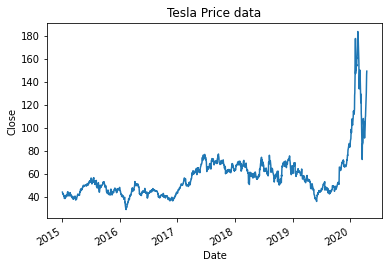

In [12]:
tesla['Close'].plot()
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Tesla Price data")
plt.show()

The next step we need to perform is to calculate and to plot the daily returns of Tesla stock price, which corresponds to the change in price of the stock price between the previous day and the current one. This is done using the pct_change function that will calculate the change between the previous value and the current one, which will espress the returns in percent. We apply this function on the `Close` column of tesla DataFrame because we're interested in the last price at which the stock traded during the day.

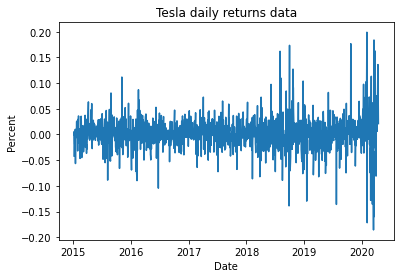

In [13]:
tesla['returns'] = tesla['Close'].pct_change()
tesla.head()
plt.plot(tesla.returns)
plt.xlabel("Date")
plt.ylabel("Percent")
plt.title("Tesla daily returns data")
plt.show()

Using a histogram, we can visualize the distribution of the returns and to see how extreme can the returns be. In this case, we can see that the returns go from -0.2 to 0.2.

[Text(0.5, 1.0, 'Tesla stock price returns')]

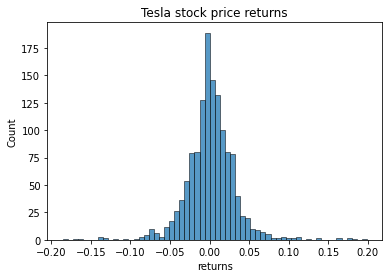

In [14]:
sns.histplot(data=tesla, x="returns",bins=60).set(title='Tesla stock price returns')

**Create a dataframe for returns:**

Here we create a dataframe that will be used later for our prediction, it contains the return with its corresponding date. Because the returns compare the previous row with the current one, the return in the first row of the dataframe is nan, and we will drop it using dropna function.


In [15]:
tesla = tesla.reset_index()
tesla.rename(columns = {'Date': 'just_date'}, inplace = True)
df_returns = tesla[['just_date','returns']].dropna()
df_returns

,just_date,returns
1,2015-01-05,-0.042041
2,2015-01-06,0.005664
3,2015-01-07,-0.001562
4,2015-01-08,-0.001564
5,2015-01-09,-0.018802
...,...,...
1326,2020-04-09,0.044020
1327,2020-04-13,0.136038
1328,2020-04-14,0.090545
1329,2020-04-15,0.028089


##Part 3 : Quotations preprocessing


**First Step : We remove punctuation**

We create a function that will remove punctuation using the string library which contains a predefined list of punctuation.



In [16]:
print ("We remove all the punctuation that follows from our quotation {}".format(string.punctuation))

We remove all the punctuation that follows from our quotation !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


Each time we find one of the punctuation listed above, the function remove_punctuation takes it off. We then apply this fuction to each quote of `df_musk` DataFrame and store this new quote in a new column `removed_punctuation`.

In [17]:
def remove_punctuation(quote):
    no_punctuation ="".join([i for i in quote if i not in string.punctuation])
    return no_punctuation

df_musk['removed_punctuation']= df_musk['quotation'].apply(lambda x:remove_punctuation(x))
df_musk.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,just_date,removed_punctuation
0,2020-03-24-078524,We are grateful for the discussion with @ElonM...,Elon Musk,[Q317521],2020-03-24 05:56:00,2,"[[Elon Musk, 0.5366], [None, 0.4634]]",[https://paloaltoonline.com/news/2020/03/23/wi...,E,2020-03-24,We are grateful for the discussion with ElonMu...
1,2020-02-07-002094,A PhD is definitely not required. All that mat...,Elon Musk,[Q317521],2020-02-07 00:00:00,1,"[[Elon Musk, 0.9278], [None, 0.0722]]",[https://www.teslarati.com/tesla-ai-autopilot-...,E,2020-02-07,A PhD is definitely not required All that matt...
2,2020-03-24-002121,addressing COVID-19 is a group effort. We are ...,Elon Musk,[Q317521],2020-03-24 18:18:25,1,"[[Elon Musk, 0.733], [None, 0.267]]",[https://www.massdevice.com/elon-musk-says-he-...,E,2020-03-24,addressing COVID19 is a group effort We are gr...
3,2020-03-09-007954,But I'd like to at least be around to see a bu...,Elon Musk,[Q317521],2020-03-09 20:30:24,2,"[[Elon Musk, 0.9132], [None, 0.0868]]",[https://www.cnbc.com/2020/03/09/spacex-plans-...,E,2020-03-09,But Id like to at least be around to see a bun...
4,2020-03-09-078624,will not cause any impact whatsoever in astron...,Elon Musk,[Q317521],2020-03-09 17:58:09,11,"[[Elon Musk, 0.815], [None, 0.1833], [Gwynne S...",[http://www.breitbart.com/news/elon-musk-dismi...,E,2020-03-09,will not cause any impact whatsoever in astron...


**Second Step : Casefolding** 

We apply on the `removed_punctuation` column the function .lower() from Python that returns lowercased strings

In [18]:
df_musk['casefold']= df_musk['removed_punctuation'].apply(lambda x: x.lower())
df_musk.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,just_date,removed_punctuation,casefold
0,2020-03-24-078524,We are grateful for the discussion with @ElonM...,Elon Musk,[Q317521],2020-03-24 05:56:00,2,"[[Elon Musk, 0.5366], [None, 0.4634]]",[https://paloaltoonline.com/news/2020/03/23/wi...,E,2020-03-24,We are grateful for the discussion with ElonMu...,we are grateful for the discussion with elonmu...
1,2020-02-07-002094,A PhD is definitely not required. All that mat...,Elon Musk,[Q317521],2020-02-07 00:00:00,1,"[[Elon Musk, 0.9278], [None, 0.0722]]",[https://www.teslarati.com/tesla-ai-autopilot-...,E,2020-02-07,A PhD is definitely not required All that matt...,a phd is definitely not required all that matt...
2,2020-03-24-002121,addressing COVID-19 is a group effort. We are ...,Elon Musk,[Q317521],2020-03-24 18:18:25,1,"[[Elon Musk, 0.733], [None, 0.267]]",[https://www.massdevice.com/elon-musk-says-he-...,E,2020-03-24,addressing COVID19 is a group effort We are gr...,addressing covid19 is a group effort we are gr...
3,2020-03-09-007954,But I'd like to at least be around to see a bu...,Elon Musk,[Q317521],2020-03-09 20:30:24,2,"[[Elon Musk, 0.9132], [None, 0.0868]]",[https://www.cnbc.com/2020/03/09/spacex-plans-...,E,2020-03-09,But Id like to at least be around to see a bun...,but id like to at least be around to see a bun...
4,2020-03-09-078624,will not cause any impact whatsoever in astron...,Elon Musk,[Q317521],2020-03-09 17:58:09,11,"[[Elon Musk, 0.815], [None, 0.1833], [Gwynne S...",[http://www.breitbart.com/news/elon-musk-dismi...,E,2020-03-09,will not cause any impact whatsoever in astron...,will not cause any impact whatsoever in astron...


**Third Step : Tokenization**

One use of this step is to determine the 10 most common words of Elon Musk quotes. To do so, we now use the function word_tokenize from NLTK library, we apply it to the column `casefold` and store the output in a new column `tokenize_quote`. 


In [19]:
df_musk['tokenize_quote'] = df_musk['casefold'].apply(lambda x: word_tokenize(x))
df_musk.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,just_date,removed_punctuation,casefold,tokenize_quote
0,2020-03-24-078524,We are grateful for the discussion with @ElonM...,Elon Musk,[Q317521],2020-03-24 05:56:00,2,"[[Elon Musk, 0.5366], [None, 0.4634]]",[https://paloaltoonline.com/news/2020/03/23/wi...,E,2020-03-24,We are grateful for the discussion with ElonMu...,we are grateful for the discussion with elonmu...,"[we, are, grateful, for, the, discussion, with..."
1,2020-02-07-002094,A PhD is definitely not required. All that mat...,Elon Musk,[Q317521],2020-02-07 00:00:00,1,"[[Elon Musk, 0.9278], [None, 0.0722]]",[https://www.teslarati.com/tesla-ai-autopilot-...,E,2020-02-07,A PhD is definitely not required All that matt...,a phd is definitely not required all that matt...,"[a, phd, is, definitely, not, required, all, t..."
2,2020-03-24-002121,addressing COVID-19 is a group effort. We are ...,Elon Musk,[Q317521],2020-03-24 18:18:25,1,"[[Elon Musk, 0.733], [None, 0.267]]",[https://www.massdevice.com/elon-musk-says-he-...,E,2020-03-24,addressing COVID19 is a group effort We are gr...,addressing covid19 is a group effort we are gr...,"[addressing, covid19, is, a, group, effort, we..."
3,2020-03-09-007954,But I'd like to at least be around to see a bu...,Elon Musk,[Q317521],2020-03-09 20:30:24,2,"[[Elon Musk, 0.9132], [None, 0.0868]]",[https://www.cnbc.com/2020/03/09/spacex-plans-...,E,2020-03-09,But Id like to at least be around to see a bun...,but id like to at least be around to see a bun...,"[but, id, like, to, at, least, be, around, to,..."
4,2020-03-09-078624,will not cause any impact whatsoever in astron...,Elon Musk,[Q317521],2020-03-09 17:58:09,11,"[[Elon Musk, 0.815], [None, 0.1833], [Gwynne S...",[http://www.breitbart.com/news/elon-musk-dismi...,E,2020-03-09,will not cause any impact whatsoever in astron...,will not cause any impact whatsoever in astron...,"[will, not, cause, any, impact, whatsoever, in..."


**Forth Step : Remove stop words**

We have to remove all the stop words that don't provide any further information to our analysis. To do so, we use a pre-existing list of stop words that we download from nltk library and we specify the language we need, ie english. Then, we crate the function remove_sw that will for each quote output all the words that are not present in the stopwords list. We can then apply this function on our dataframe and store this new step into a new column `remove_sw`.

In [20]:
sw = stopwords.words('english')
def remove_sw(quote):
  quote_no_sw = [word for word in quote if not word in sw]
  return quote_no_sw 
df_musk['remove_sw'] = df_musk['tokenize_quote'].apply(lambda x: remove_sw(x))
df_musk.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,just_date,removed_punctuation,casefold,tokenize_quote,remove_sw
0,2020-03-24-078524,We are grateful for the discussion with @ElonM...,Elon Musk,[Q317521],2020-03-24 05:56:00,2,"[[Elon Musk, 0.5366], [None, 0.4634]]",[https://paloaltoonline.com/news/2020/03/23/wi...,E,2020-03-24,We are grateful for the discussion with ElonMu...,we are grateful for the discussion with elonmu...,"[we, are, grateful, for, the, discussion, with...","[grateful, discussion, elonmusk, tesla, work, ..."
1,2020-02-07-002094,A PhD is definitely not required. All that mat...,Elon Musk,[Q317521],2020-02-07 00:00:00,1,"[[Elon Musk, 0.9278], [None, 0.0722]]",[https://www.teslarati.com/tesla-ai-autopilot-...,E,2020-02-07,A PhD is definitely not required All that matt...,a phd is definitely not required all that matt...,"[a, phd, is, definitely, not, required, all, t...","[phd, definitely, required, matters, deep, und..."
2,2020-03-24-002121,addressing COVID-19 is a group effort. We are ...,Elon Musk,[Q317521],2020-03-24 18:18:25,1,"[[Elon Musk, 0.733], [None, 0.267]]",[https://www.massdevice.com/elon-musk-says-he-...,E,2020-03-24,addressing COVID19 is a group effort We are gr...,addressing covid19 is a group effort we are gr...,"[addressing, covid19, is, a, group, effort, we...","[addressing, covid19, group, effort, grateful,..."
3,2020-03-09-007954,But I'd like to at least be around to see a bu...,Elon Musk,[Q317521],2020-03-09 20:30:24,2,"[[Elon Musk, 0.9132], [None, 0.0868]]",[https://www.cnbc.com/2020/03/09/spacex-plans-...,E,2020-03-09,But Id like to at least be around to see a bun...,but id like to at least be around to see a bun...,"[but, id, like, to, at, least, be, around, to,...","[id, like, least, around, see, bunch, ships, l..."
4,2020-03-09-078624,will not cause any impact whatsoever in astron...,Elon Musk,[Q317521],2020-03-09 17:58:09,11,"[[Elon Musk, 0.815], [None, 0.1833], [Gwynne S...",[http://www.breitbart.com/news/elon-musk-dismi...,E,2020-03-09,will not cause any impact whatsoever in astron...,will not cause any impact whatsoever in astron...,"[will, not, cause, any, impact, whatsoever, in...","[cause, impact, whatsoever, astronomical, disc..."


**Fifth Step : Lemmatization**

Finally, we need to map different form of words into a single form. To do so, one can either choose stemming or lemmatization, however, this last one is more meaningful because it uses the word context instead of just the word radical, so it gives more accurate mapping. We create a function that uses the existing WordNetLemmatizer from the nltk library, and returns a lemmatized version of the words we had in each quote. Again, we store this return in the new column `lemmatized_quote`.

In [21]:
wordnet_lemmatizer = WordNetLemmatizer()

In [22]:
def lemmatize_quotation(quotation):
  lemm_quotation = [wordnet_lemmatizer.lemmatize(word) for word in quotation]
  return lemm_quotation

df_musk['lemmatized_quote']= df_musk['remove_sw'].apply(lambda x: lemmatize_quotation(x))
df_musk.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,just_date,removed_punctuation,casefold,tokenize_quote,remove_sw,lemmatized_quote
0,2020-03-24-078524,We are grateful for the discussion with @ElonM...,Elon Musk,[Q317521],2020-03-24 05:56:00,2,"[[Elon Musk, 0.5366], [None, 0.4634]]",[https://paloaltoonline.com/news/2020/03/23/wi...,E,2020-03-24,We are grateful for the discussion with ElonMu...,we are grateful for the discussion with elonmu...,"[we, are, grateful, for, the, discussion, with...","[grateful, discussion, elonmusk, tesla, work, ...","[grateful, discussion, elonmusk, tesla, work, ..."
1,2020-02-07-002094,A PhD is definitely not required. All that mat...,Elon Musk,[Q317521],2020-02-07 00:00:00,1,"[[Elon Musk, 0.9278], [None, 0.0722]]",[https://www.teslarati.com/tesla-ai-autopilot-...,E,2020-02-07,A PhD is definitely not required All that matt...,a phd is definitely not required all that matt...,"[a, phd, is, definitely, not, required, all, t...","[phd, definitely, required, matters, deep, und...","[phd, definitely, required, matter, deep, unde..."
2,2020-03-24-002121,addressing COVID-19 is a group effort. We are ...,Elon Musk,[Q317521],2020-03-24 18:18:25,1,"[[Elon Musk, 0.733], [None, 0.267]]",[https://www.massdevice.com/elon-musk-says-he-...,E,2020-03-24,addressing COVID19 is a group effort We are gr...,addressing covid19 is a group effort we are gr...,"[addressing, covid19, is, a, group, effort, we...","[addressing, covid19, group, effort, grateful,...","[addressing, covid19, group, effort, grateful,..."
3,2020-03-09-007954,But I'd like to at least be around to see a bu...,Elon Musk,[Q317521],2020-03-09 20:30:24,2,"[[Elon Musk, 0.9132], [None, 0.0868]]",[https://www.cnbc.com/2020/03/09/spacex-plans-...,E,2020-03-09,But Id like to at least be around to see a bun...,but id like to at least be around to see a bun...,"[but, id, like, to, at, least, be, around, to,...","[id, like, least, around, see, bunch, ships, l...","[id, like, least, around, see, bunch, ship, la..."
4,2020-03-09-078624,will not cause any impact whatsoever in astron...,Elon Musk,[Q317521],2020-03-09 17:58:09,11,"[[Elon Musk, 0.815], [None, 0.1833], [Gwynne S...",[http://www.breitbart.com/news/elon-musk-dismi...,E,2020-03-09,will not cause any impact whatsoever in astron...,will not cause any impact whatsoever in astron...,"[will, not, cause, any, impact, whatsoever, in...","[cause, impact, whatsoever, astronomical, disc...","[cause, impact, whatsoever, astronomical, disc..."


<hr style="border:2px solid gray"> </hr>


## Part 4 most common words + filtering the dataframe

**Analyse Elon Musk's quotation:**

Here we decided to explore Elon Musk's quotations to get an insight of our data and to which extent we can use this data for our goal project. 
First we will find the most common words in order to determine what are the predominant topics of Elon Musk's quotations. 

The first thing to do is to put all the quotes in a single string `all_words_list`. Then, we calculate the frequency of each word in this string using the function FreqDist fron nltk library. Then from the output `freq` we create the DataFrame `freq_df` that will contain all the words of the quotation and their frequencies. We sort the column `Count` so that we have the most frequent words at the beggining of the DataFrame and we select the 20 first ones


In [23]:
all_words = df_musk['lemmatized_quote'].tolist()
all_words_list = [item for sublist in all_words for item in sublist]
freq = nltk.FreqDist(all_words_list)
freq_df = pd.DataFrame({'Word': list(freq.keys()), 'Count': list(freq.values())}).sort_values(by=['Count'], ascending=False)
freq_df = freq_df.iloc[0:20,:]
freq_df

,Word,Count
3,tesla,4501
136,car,4417
161,think,3698
49,like,3551
352,would,2977
200,going,2948
77,people,2906
138,year,2714
460,model,2661
204,really,2458


We see that the 2 first words are Tesla and cars, which seems to be the proheminents topic, and so emphasizes the interest of Elon Musk in Tesla and the automotive industry among others.

Also, we can see that the step where we removed the stopwords wasn't totally efficient : the fact that we removed the punctuation first a fait qu'on a enleve l'apostrophe et que les mots comme don't qui deviennent alors dont ne sont pas supprimées. However, we do get the main topic of the quotes based on the two first most common word in all the quotes.

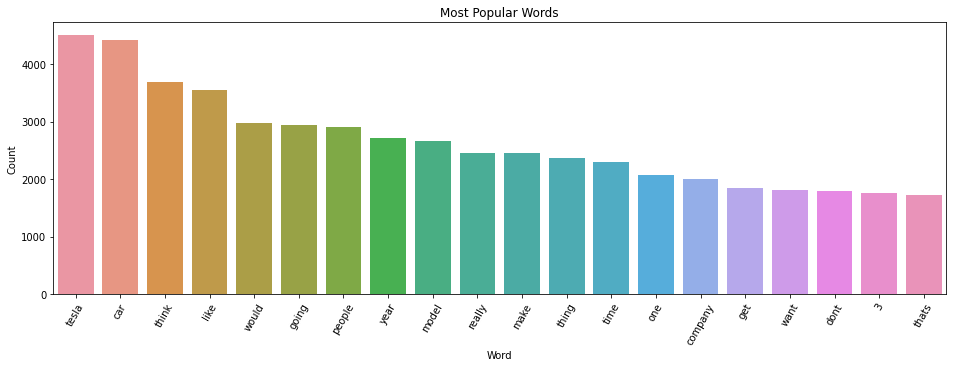

In [24]:
plt.figure(figsize=(16,5))
ax = sns.barplot(data=freq_df, x= "Word", y = "Count")
ax.set_ylabel('Count')
ax.set_xlabel('Word')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
ax.set_title("Most Popular Words")
plt.show()

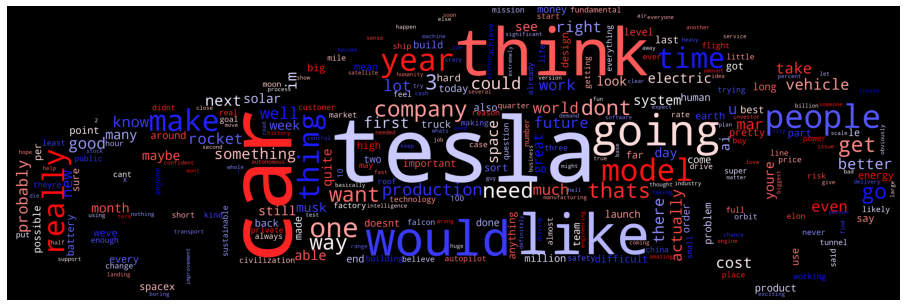

In [25]:
wordcloud = WordCloud(max_words=300,
                      scale=3,
                      relative_scaling=0.5,
                      background_color='black',
                      mask = np.array(Image.open('/content/drive/MyDrive/car_tesla.jpg')),
                      colormap='bwr',
                      normalize_plurals=True,).generate_from_frequencies(freq)
plt.figure(figsize=(16,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Now that we have get the main dataset preprocessed, we can select from our dataframe all the quotes that contains some key words in order to create a more specific data frame with these quotes. The list of key words is selected based on the most common words obtained and the topic we're interested in.

In [27]:
filtered_indexes = []
key_word = ['tesla','car','vehicle']
length = len(df_musk.quotation)
for k in range(len(key_word)):
  for i in range (length):
    quote = df_musk.iloc[i]['quotation']
    if key_word[k] in quote.lower():
        filtered_indexes.append(i)

print(len(filtered_indexes))
df_tesla = df_musk.iloc[filtered_indexes]
df_tesla

9750


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,just_date,removed_punctuation,casefold,tokenize_quote,remove_sw,lemmatized_quote,selected_quotes
0,2020-03-24-078524,We are grateful for the discussion with @ElonM...,Elon Musk,[Q317521],2020-03-24 05:56:00,2,"[[Elon Musk, 0.5366], [None, 0.4634]]",[https://paloaltoonline.com/news/2020/03/23/wi...,E,2020-03-24,We are grateful for the discussion with ElonMu...,we are grateful for the discussion with elonmu...,"[we, are, grateful, for, the, discussion, with...","[grateful, discussion, elonmusk, tesla, work, ...","[grateful, discussion, elonmusk, tesla, work, ...",True
2,2020-03-24-002121,addressing COVID-19 is a group effort. We are ...,Elon Musk,[Q317521],2020-03-24 18:18:25,1,"[[Elon Musk, 0.733], [None, 0.267]]",[https://www.massdevice.com/elon-musk-says-he-...,E,2020-03-24,addressing COVID19 is a group effort We are gr...,addressing covid19 is a group effort we are gr...,"[addressing, covid19, is, a, group, effort, we...","[addressing, covid19, group, effort, grateful,...","[addressing, covid19, group, effort, grateful,...",True
5,2020-01-29-004715,"Also, you can request any service from the Tes...",Elon Musk,[Q317521],2020-01-29 00:00:00,1,"[[Elon Musk, 0.7879], [None, 0.2121]]",[https://www.teslarati.com/tesla-mobile-servic...,E,2020-01-29,Also you can request any service from the Tesl...,also you can request any service from the tesl...,"[also, you, can, request, any, service, from, ...","[also, request, service, tesla, phone, app, mi...","[also, request, service, tesla, phone, app, mi...",True
9,2020-02-17-057451,Tesla's innovation strategy -- which focuses o...,Elon Musk,[Q317521],2020-02-17 00:00:00,1,"[[Elon Musk, 0.5602], [None, 0.4398]]",[http://www.techinsider.io/elon-musk-innovatio...,E,2020-02-17,Teslas innovation strategy which focuses on t...,teslas innovation strategy which focuses on t...,"[teslas, innovation, strategy, which, focuses,...","[teslas, innovation, strategy, focuses, transf...","[tesla, innovation, strategy, focus, transform...",True
13,2020-01-27-051967,Mr Musk deserves credit for establishing a pur...,Elon Musk,[Q317521],2020-01-27 09:45:20,1,"[[Elon Musk, 0.8577], [None, 0.1044], [Michael...",[https://www.carbonbrief.org/daily-brief/citiz...,E,2020-01-27,Mr Musk deserves credit for establishing a pur...,mr musk deserves credit for establishing a pur...,"[mr, musk, deserves, credit, for, establishing...","[mr, musk, deserves, credit, establishing, pur...","[mr, musk, deserves, credit, establishing, pur...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43514,2015-01-06-029560,If one can figure out how to effectively reuse...,Elon Musk,[Q317521],2015-01-06 11:01:17,8,"[[Elon Musk, 0.816], [None, 0.1807], [Anthony ...",[http://www.shropshirestar.com/news/uk-news/20...,E,2015-01-06,If one can figure out how to effectively reuse...,if one can figure out how to effectively reuse...,"[if, one, can, figure, out, how, to, effective...","[one, figure, effectively, reuse, rockets, lik...","[one, figure, effectively, reuse, rocket, like...",True
43533,2015-01-16-084637,We are considering in the long term future veh...,Elon Musk,[Q317521],2015-01-16 12:18:31,1,"[[Elon Musk, 0.8964], [None, 0.1036]]",[http://radio.woai.com/articles/woai-local-new...,E,2015-01-16,We are considering in the long term future veh...,we are considering in the long term future veh...,"[we, are, considering, in, the, long, term, fu...","[considering, long, term, future, vehicle, bat...","[considering, long, term, future, vehicle, bat...",True
43555,2015-04-04-006764,EV vs. fuel cell vehicle,Elon Musk,[Q317521],2015-04-04 15:44:02,2,"[[Elon Musk, 0.5509], [None, 0.4491]]",[http://www.fool.com/investing/general/2015/04...,E,2015-04-04,EV vs fuel cell vehicle,ev vs fuel cell vehicle,"[ev, vs, fuel, cell, vehicle]","[ev, vs, fuel, cell, vehicle]","[ev, v, fuel, cell, vehicle]",True
43558,2015-10-03-030805,It's important to show that any type

We can also plot the distribution of Elon Musk quotes in which he mentions Tesla.

Text(0.5, 1.0, 'Number of Elon Musk quotes per day')

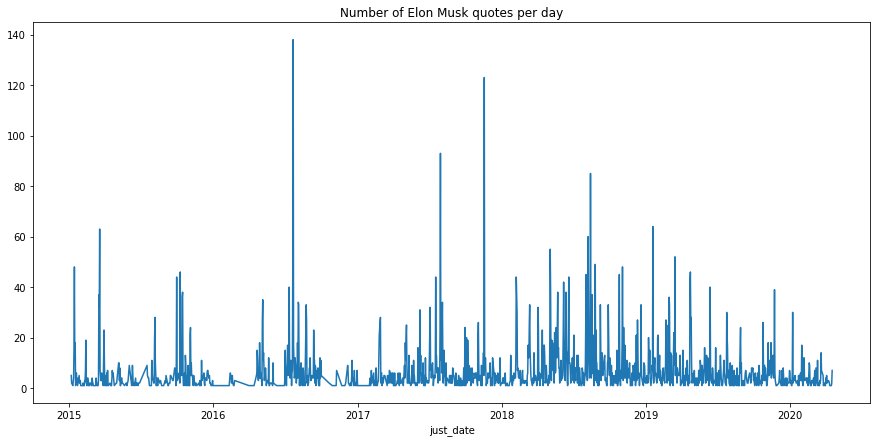

In [28]:
fig,ax = plt.subplots(figsize =(15,7))
df_tesla.groupby(by='just_date').count()['quotation'].plot(ax=ax)
ax.set_title('Number of Elon Musk quotes per day') ### something is wrong here  

## Part 5: Sentiment analysis

**Vader sentiment analysis :**

This model returns the compound score that informs if the quote is positive (compound>=0.05), neutral(-0.5>compound>0.05) or negative(compound >= -0.05). These conditions are grouped in the function decide_sentiment that will return for each quote the corresponding sentiment predicted. It also gives three other metrics, positive, neutral or negative.

Also, we apply these sentiment analyses on the quotation without any preprocessing. Indeed, the punctuation or the uppercase can be informative in our case to predict the sentiment of a quote.

In [29]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
df_sentiment_vader = df_tesla['quotation'].apply(lambda x: sid.polarity_scores(x).get('compound'))


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Below, we create a dataframe that will contain the output of the Vader Sentiment Analysis model, with a column for the categorical and the continuous return. We create two functions that returns this categorisation : 1 corresponds to positive, 0 correponds to neutral and -1 corresponds to negative sentiment.

In [30]:
def decide_sentiment(x):
  if x >= 0.05 :
      return 1
  elif x <= - 0.05 :
      return -1
  else :
      return 0

In [31]:
df_sentiment = df_tesla[['just_date']].copy()
df_sentiment["vader_sentiment"] = df_sentiment_vader.apply(lambda x: decide_sentiment(x))
df_sentiment["vader_sentiment_continuous"] = df_sentiment_vader
df_sentiment

,just_date,vader_sentiment,vader_sentiment_continuous
0,2020-03-24,1,0.2732
2,2020-03-24,1,0.2732
5,2020-01-29,0,0.0000
9,2020-02-17,1,0.3818
13,2020-01-27,1,0.5647
...,...,...,...
43514,2015-01-06,1,0.6597
43533,2015-01-16,1,0.7351
43555,2015-04-04,0,0.0000
43558,2015-10-03,1,0.2023


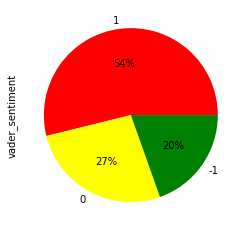

In [32]:
df_sentiment.vader_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

**Textblob sentiment analysis**:

For the second model, we used TextBlob, another pretrained model to do the sentiment analysis. This model returns two values : the polarity (ie how much a quote is positive or negative) in a range between -1 and 1, and the subjectivity (ie how much the content of a quote is objective or not) in a range between 0 and 1. 

As before, we create the function decide_subjectivity that give a categorized return : either subjective if the subjectivity >= 0.5 (1) or objective if subjectivity < 0,5 (0). Then, we can keep both categorized and continuous variables in `df_sentiment` dataframe for both the polarity and subjectivity.

In [33]:
def decide_subjectivity(x):
  if x >= 0.5:
      return 1
  else :
      return 0

In [34]:
df_sentiment_blob = df_tesla['quotation'].apply(lambda x: TextBlob(x).sentiment)
df_sentiment["blob_sentiment"] = df_sentiment_blob.apply(lambda x: decide_sentiment(x.polarity))
df_sentiment["blob_sentiment_continuous"] = df_sentiment_blob.apply(lambda x: x.polarity)
df_sentiment

,just_date,vader_sentiment,vader_sentiment_continuous,blob_sentiment,blob_sentiment_continuous
0,2020-03-24,1,0.2732,0,0.000000
2,2020-03-24,1,0.2732,0,0.000000
5,2020-01-29,0,0.0000,0,0.000000
9,2020-02-17,1,0.3818,1,0.150000
13,2020-01-27,1,0.5647,1,0.188312
...,...,...,...,...,...
43514,2015-01-06,1,0.6597,1,0.333333
43533,2015-01-16,1,0.7351,1,0.127778
43555,2015-04-04,0,0.0000,0,0.000000
43558,2015-10-03,1,0.2023,1,0.400000


In [35]:
df_sentiment["blob_subjectivity"] = df_sentiment_blob.apply(lambda x: decide_subjectivity(x.subjectivity))
df_sentiment["blob_subjectivity_continuous"] = df_sentiment_blob.apply(lambda x: x.subjectivity)
df_sentiment

,just_date,vader_sentiment,vader_sentiment_continuous,blob_sentiment,blob_sentiment_continuous,blob_subjectivity,blob_subjectivity_continuous
0,2020-03-24,1,0.2732,0,0.000000,0,0.000000
2,2020-03-24,1,0.2732,0,0.000000,0,0.000000
5,2020-01-29,0,0.0000,0,0.000000,0,0.000000
9,2020-02-17,1,0.3818,1,0.150000,0,0.200000
13,2020-01-27,1,0.5647,1,0.188312,0,0.335758
...,...,...,...,...,...,...,...
43514,2015-01-06,1,0.6597,1,0.333333,0,0.400000
43533,2015-01-16,1,0.7351,1,0.127778,0,0.419444
43555,2015-04-04,0,0.0000,0,0.000000,0,0.000000
43558,2015-10-03,1,0.2023,1,0.400000,1,1.000000


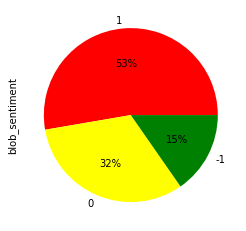

In [36]:
df_sentiment.blob_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

We can visualize the relationship between both outputs of TextBlob model using a scatter histogram

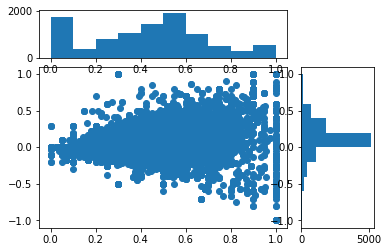

In [37]:
from matplotlib.gridspec import GridSpec

fig = plt.figure()
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_x = fig.add_subplot(gs[0,0:3])
ax_hist_y = fig.add_subplot(gs[1:4, 3])

ax_scatter.scatter(df_sentiment['blob_subjectivity_continuous'], df_sentiment['blob_sentiment_continuous'])

ax_hist_x.hist(df_sentiment['blob_subjectivity_continuous'])
ax_hist_y.hist(df_sentiment['blob_sentiment_continuous'], orientation = 'horizontal')

plt.show()

**Conparing the 2 models**

One question we can ask ourselves is if both Vader and TextBlob yields the same sentiment prediction. A first idea can be obtained by plotting the distribution of the sentiment analysis output. 

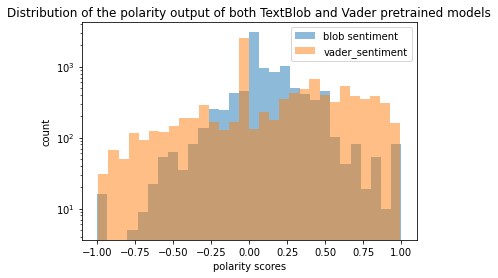

In [38]:
plt.hist(df_sentiment['blob_sentiment_continuous'], bins=30, alpha=0.5, label='blob sentiment',log=True)
plt.hist(df_sentiment['vader_sentiment_continuous'], bins=30, alpha=0.5, label='vader_sentiment',log=True)
plt.xlabel('polarity scores')
plt.ylabel('count')
plt.legend(loc = 'best')
plt.title('Distribution of the polarity output of both TextBlob and Vader pretrained models')
plt.show()

We can also calculate the mean and the standard error fo the mean of the scores of both model :

In [39]:
mean_blob = df_sentiment.blob_sentiment_continuous.mean()
mean_vader = df_sentiment.vader_sentiment_continuous.mean()

In [40]:
print(f'The mean of the score of the blob model is : {mean_blob}')
print(f'The mean of the score of vader model is : {mean_vader}')


The mean of the score of the blob model is : 0.11200921572470705
The mean of the score of vader model is : 0.19657212307692265


To determine if the difference in means between the two models is statistically significant, we perform a ttest. The null hypothesis is that the means of both models are equal whereas the alternative hypothesis is that their means are different. 

In [41]:
ttest_ind(df_sentiment['blob_sentiment_continuous'], df_sentiment['vader_sentiment_continuous'])

Ttest_indResult(statistic=-16.99060899540258, pvalue=2.7971325778534723e-64)

As we can see from the t-test result, the p-value is really small (p < 0.05). We can thus reject the null hypotesis (equal means) and confirm that the difference in means between the two models is statistically significant.

Also, another visualization possible is the use of boxplots. We can see that when the quote is objective, the interquartile range is close to 0, which corresponds to a neutral sentiment, whereas quotes that are categorized subjectives express more sentiments in it.

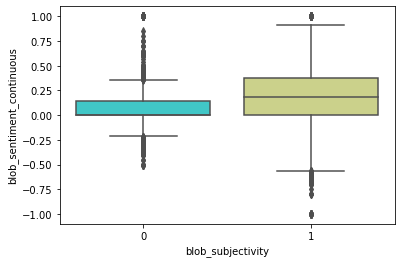

In [42]:
sns.boxplot(x='blob_subjectivity',y='blob_sentiment_continuous',data=df_sentiment, palette='rainbow')


We prepare a new dataframe that will contain the output of both models and the stock market returns for the next step that is a linear regression. Because for a specific day, we can have several quotes, we need to aggregate the scores obtained for each quote by using the mean of the scores. To do so, we group by date `df_sentiment` and calculate the mean of the continuous variables in each column for each group. Now that we have one score value per day for each model, we can concatenate this dataframe with `df_returns` obtained previously, and we obtain the dataframe `result` in which we have one date per row, with the output of both models and the stock return corresponding to this day. 

In our analyses, we make the hypothesis that the influence that Elon Musk can have on Tesla stock price can be seen the same day.

In [43]:
grouped_by_date_df = df_sentiment.groupby('just_date',as_index=False).mean() #we aggregate all the quotations which were said on this day 
grouped_by_date_df['just_date']= pd.to_datetime(grouped_by_date_df.just_date) 
grouped_by_date_df.head()

,just_date,vader_sentiment,vader_sentiment_continuous,blob_sentiment,blob_sentiment_continuous,blob_subjectivity,blob_subjectivity_continuous
0,2015-01-06,0.200,0.276160,0.0000,0.083333,0.0000,0.310000
1,2015-01-07,1.000,0.648600,-1.0000,-0.141667,0.0000,0.458333
2,2015-01-10,-1.000,-0.571900,-1.0000,-0.500000,0.0000,0.300000
3,2015-01-12,0.000,-0.147225,0.2500,0.028452,1.0000,0.739286
4,2015-01-13,0.375,0.155181,0.0625,0.033952,0.4375,0.444976


We set the date as new indexes of both dataframes `grouped_by_date_df` and `result` to be able to concatenate them into a new common dataframe

In [44]:
grouped_by_date_df = grouped_by_date_df.set_index('just_date')
df_returns = df_returns.set_index('just_date')
result = pd.concat([grouped_by_date_df, df_returns], axis=1)
result

,vader_sentiment,vader_sentiment_continuous,blob_sentiment,blob_sentiment_continuous,blob_subjectivity,blob_subjectivity_continuous,returns
just_date,,,,,,,
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,-0.042041
2015-01-06,0.200000,0.276160,0.0,0.083333,0.000000,0.310000,0.005664
2015-01-07,1.000000,0.648600,-1.0,-0.141667,0.000000,0.458333,-0.001562
2015-01-08,NaN,NaN,NaN,NaN,NaN,NaN,-0.001564
2015-01-09,NaN,NaN,NaN,NaN,NaN,NaN,-0.018802
...,...,...,...,...,...,...,...
2020-04-10,1.000000,0.318200,0.0,0.000000,1.000000,1.000000,NaN
2020-04-13,NaN,NaN,NaN,NaN,NaN,NaN,0.136038
2020-04-14,1.000000,0.318200,0.0,0.037500,0.000000,0.312500,0.090545


We have many NaN values in this dataframe. The first reason is that we can have some days in which no quotes were said. We decided to fill the values with the score of the day before, because this quote will be the last thing Elon Musk said and according to our hypothesis represent a factor that can play a role in the evolution of the stock price. The other reason is because there are no returns on weekends or on holidays. So the weekend quotes and their corresponding scores are aggregated with mondays quotes because we can only assess their effect on monday's stock price.

In [45]:
#there are some day where no quotation have been said so we fix this by replicating what was said on the day before 
result.vader_sentiment_continuous.fillna(method='ffill',inplace = True)
result.blob_sentiment_continuous.fillna(method='ffill',inplace = True)
result.blob_subjectivity_continuous.fillna(method='ffill',inplace = True)


Using the function weekday, we can know to which day corresponds a specific date and thus spot the weekends. We then computed the function fixReturns. Three possibilities are possible : we have the complete weekend, or we can have only quotes on Saturday or Sunday, or finally no quotes were said during the weekend. For each of these conditions, we aggregare the data using the mean of the scor for the days we have.

In [46]:
result.reset_index(inplace = True) 
result['weekday'] = result['just_date'].apply(lambda x: x.weekday())
result

,just_date,vader_sentiment,vader_sentiment_continuous,blob_sentiment,blob_sentiment_continuous,blob_subjectivity,blob_subjectivity_continuous,returns,weekday
0,2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,-0.042041,0
1,2015-01-06,0.200000,0.276160,0.0,0.083333,0.000000,0.310000,0.005664,1
2,2015-01-07,1.000000,0.648600,-1.0,-0.141667,0.000000,0.458333,-0.001562,2
3,2015-01-08,NaN,0.648600,NaN,-0.141667,NaN,0.458333,-0.001564,3
4,2015-01-09,NaN,0.648600,NaN,-0.141667,NaN,0.458333,-0.018802,4
...,...,...,...,...,...,...,...,...,...
1687,2020-04-10,1.000000,0.318200,0.0,0.000000,1.000000,1.000000,NaN,4
1688,2020-04-13,NaN,0.318200,NaN,0.000000,NaN,1.000000,0.136038,0
1689,2020-04-14,1.000000,0.318200,0.0,0.037500,0.000000,0.312500,0.090545,1
1690,2020-04-15,0.000000,0.341750,1.0,0.288988,0.000000,0.409524,0.028089,2


In [47]:
 def fixReturns(row): 

  indexFirstAnt = row.name - 1 
  indexSecondAnt = row.name - 2 

  onlySaturday = False 
  onlySunday = False 
  weekend  = False

  if indexFirstAnt >= 0:
    onlySaturday = ((row['weekday'] == 0) & (result.iloc[indexFirstAnt,5] == 5)) #only saturday stock the value of indexFirstAnt
  if indexSecondAnt >= 0 & indexFirstAnt >= 0:
    onlySunday = (((row['weekday'] == 0)  & (result.iloc[indexFirstAnt,5] == 6)) & (result.iloc[indexSecondAnt,5] != 5)) #only sunday stock the value of indexFirstAnt
    weekend = (((row['weekday'] == 0)  & (result.iloc[indexFirstAnt,5] == 6)) & (result.iloc[indexSecondAnt,5] == 5)) #all the weekend aggregate 
    
  if weekend:
    agg_vader = (result.iloc[indexFirstAnt, 1] + result.iloc[indexSecondAnt, 1] + row.vader_sentiment_continuous)/3  #vader_sentiment_continuous
    agg_blob_sent = (result.iloc[indexFirstAnt, 2] + result.iloc[indexSecondAnt, 2] + row.blob_sentiment_continuous)/3 #blob_sentiment_continuous
    agg_blob_subj = (result.iloc[indexFirstAnt, 3] + result.iloc[indexSecondAnt, 3] + row.blob_subjectivity_continuous)/3 #blob_subjectivity_continuous
    return (agg_vader, agg_blob_sent,agg_blob_subj)
  elif onlySaturday | onlySunday: 
    agg_vader = (result.iloc[indexFirstAnt, 1] + row.vader_sentiment_continuous)/2
    agg_blob_sent = (result.iloc[indexFirstAnt, 2] + row.blob_sentiment_continuous)/2
    agg_blob_subj = (result.iloc[indexFirstAnt, 3] + row.blob_subjectivity_continuous)/2
    return (agg_vader, agg_blob_sent,agg_blob_subj)
  else:   #no weekend do nothing
    return (row.vader_sentiment_continuous, row.blob_sentiment_continuous,row.blob_subjectivity_continuous)
def example(x): 
  return x.name - 1 

df= result.apply(lambda x: fixReturns(x), axis=1)


In [48]:
#save the values back in the dataframe 
columns = ("vader_sentiment_continuous blob_sentiment_continuous blob_subjectivity_continuous" ).split()
result.iloc[:,1:4] = pd.DataFrame([[a, b, c] for a,b,c in df.values], columns=columns)

Now that we have replicated the values of the sentiment analysis during the weekends we can safely drop the rows where we have a null return. 

In [49]:
result.dropna(inplace = True)
result.head()

,just_date,vader_sentiment,vader_sentiment_continuous,blob_sentiment,blob_sentiment_continuous,blob_subjectivity,blob_subjectivity_continuous,returns,weekday
1,2015-01-06,0.276160,0.083333,0.310000,0.083333,0.000000,0.310000,0.005664,1
2,2015-01-07,0.648600,-0.141667,0.458333,-0.141667,0.000000,0.458333,-0.001562,2
6,2015-01-12,-0.147225,0.028452,0.739286,0.028452,1.000000,0.739286,-0.021533,0
7,2015-01-13,0.155181,0.033952,0.444976,0.033952,0.437500,0.444976,0.010088,1
8,2015-01-14,0.120817,0.097388,0.336081,0.097388,0.291667,0.336081,-0.056597,2


Finally, we can perform a linear regression using as independant variables `vader_sentiment_continuous`, `blob_sentiment_continuous`,`blob_subjectivity_continuous` to estimate the stock returns. We see that R squared value is equal to 0.002, so the model doesn't fit the dataset. Plus, none of the independant variables are statistically significant to estimate the returns with this model.

In [50]:
mod = smf.ols(formula='returns ~ vader_sentiment_continuous + blob_sentiment_continuous + blob_subjectivity_continuous', data=result)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8211
Date:                Fri, 17 Dec 2021   Prob (F-statistic):              0.440
Time:                        22:30:18   Log-Likelihood:                 2051.9
No. Observations:                1047   AIC:                            -4098.
Df Residuals:                    1044   BIC:                            -4083.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

## TF-IDF Method exploration 

The aim of this part is to use the TF-IDF process on the quotes to add more features into the analysis. This step is expected to make the correlations more robust. 

The first thing to do here is to use the `TfidfVectorizer` available in sklearn in order to get the TF-IDF matrix, the maximum number of features being `100` : 

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english',max_features=100)

In [52]:
tfidf_x = vectorizer.fit_transform(df_tesla['casefold'])
tfidf_matrix = tfidf_x.toarray()
tfidf_matrix

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.78491827,
        0.        ]])

Now that we have the matrix, we can concatenate it with the `df_tesla` (the dataframe containing all the relevant quotes), creating a new dataframe named `tfidf_df` :

In [53]:
tfidf_dataframe = pd.DataFrame(tfidf_matrix)

In [54]:
df_tesla = df_tesla.reset_index()

In [55]:
tfidf_df = pd.concat([df_tesla, tfidf_dataframe], axis=1)

We add to this dataframe the two sentiment analysis results computed before :

In [56]:
df_sentiment = df_sentiment.reset_index()

In [57]:
tfidf_df["vader_sentiment"] = df_sentiment['vader_sentiment']
tfidf_df["textblob_sentiment"] = df_sentiment['blob_sentiment']

In [58]:
tfidf_df.head()

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,just_date,removed_punctuation,casefold,tokenize_quote,remove_sw,lemmatized_quote,selected_quotes,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,...,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,vader_sentiment,textblob_sentiment
0,0,2020-03-24-078524,We are grateful for the discussion with @ElonM...,Elon Musk,[Q317521],2020-03-24 05:56:00,2,"[[Elon Musk, 0.5366], [None, 0.4634]]",[https://paloaltoonline.com/news/2020/03/23/wi...,E,2020-03-24,We are grateful for the discussion with ElonMu...,we are grateful for the discussion with elonmu...,"[we, are, grateful, for, the, discussion, with...","[grateful, discussion, elonmusk, tesla, work, ...","[grateful, discussion, elonmusk, tesla, work, ...",True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.273442,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707815,0.0,0.000000,0.0,0.0,1,0
1,2,2020-03-24-002121,addressing COVID-19 is a group effort. We are ...,Elon Musk,[Q317521],2020-03-24 18:18:25,1,"[[Elon Musk, 0.733], [None, 0.267]]",[https://www.massdevice.com/elon-musk-says-he-...,E,2020-03-24,addressing COVID19 is a group effort We are gr...,addressing covid19 is a group effort we are gr...,"[addressing, covid19, is, a, group, effort, we...","[addressing, covid19, group, effort, grateful,...","[addressing, covid19, group, effort, grateful,...",True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.190552,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.493250,0.0,0.000000,0.0,0.0,1,0
2,5,2020-01-29-004715,"Also, you can request any service from the Tes...",Elon Musk,[Q317521],2020-01-29 00:00:00,1,"[[Elon Musk, 0.7879], [None, 0.2121]]",[https://www.teslarati.com/tesla-mobile-servic...,E,2020-01-29,Also you can request any service from the Tesl...,also you can request any service from the tesl...,"[also, you, can, request, any, service, from, ...","[also, request, service, tesla, phone, app, mi...","[also, request, service, tesla, phone, app, mi...",True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0,0
3,9,2020-02-17-057451,Tesla's innovation strategy -- which focuses o...,Elon Musk,[Q317521],2020-02-17 00:00:00,1,"[[Elon Musk, 0.5602], [None, 0.4398]]",[http://www.techinsider.io/elon-musk-innovatio...,E,2020-02-17,Teslas innovation strategy which focuses on t...,teslas innovation strategy which focuses on t...,"[teslas, innovation, strategy, which, focuses,...","[teslas, innovation, strategy, focuses, transf...","[tesla, innovation, strategy, focus, transform...",True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1,1
4,13,2020-01-27-051967,Mr Musk deserves credit for establishing a pur...,Elon Musk,[Q317521],2020-01-27 09:45:20,1,"[[Elon Musk, 0.8577], [None, 0.1044], [Michael...",[https://www.carbonbrief.org/daily-brief/citiz...,E,2020-01-27,Mr Musk deserves credit for establishing a pur...,mr musk deserves credit for establishing a pur...,"[mr, musk, deserves, credit, for, establishing...","[mr, musk, deserves, credit, establishing, pur...","[mr, musk, deserves, credit, establishing, pur...",True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

Now that we have all the needed data, we create the final dataframe from the previous one by joining the stock returns, computed above as `df_returns`, using `join`. This way, we accord the same return to all the quotes said on the same day : 

In [59]:
tfidf_df_returns = tfidf_df.reset_index().set_index('just_date').join(df_returns)

**Function definition : `stock_shift`**

In [60]:
def stock_shift(stock_return):
    # Computes a categorical feature representing the stock shift 
    
    # Parameters :
    # stock_return : The stock return in a given day   
    
    # Returns : The stock shift, 1 if up, 0 if down.  
    
  if stock_return >= 0:
      return 1
  elif stock_return < 0:
      return 0

Using the defined function, we add the column `stock_shift` to the dataframe :

In [61]:
tfidf_df_returns["stock_shift"] = tfidf_df_returns['returns'].apply(lambda x: stock_shift(x))

It is known that there's no data on stock prices during the weekends. As a consequence, the added column necessarily contains missing values. For the sake of the next analyses, we drop all of them :  

In [62]:
tfidf_df_returns[tfidf_df_returns["stock_shift"].isnull()].shape[0]

1390

In [63]:
tfidf_df_returns[tfidf_df_returns['stock_shift'] == 0].shape[0]

4228

In [64]:
tfidf_df_returns[tfidf_df_returns['stock_shift'] == 1].shape[0]

4132

In [65]:
tfidf_df_returns[tfidf_df_returns.returns.isnull()].shape[0] #Sanity check to verify if there's the same number of null values in both returns and stock shifts. 

1390

In [66]:
tfidf_df_returns = tfidf_df_returns.dropna(subset=['returns'])

In [67]:
tfidf_df_returns[tfidf_df_returns.returns.isnull()].shape[0]

0

***Linear regression model*** 

Let's take a look into the dataframe obtained through the previous process : 

In [68]:
tfidf_df_returns.head()

,level_0,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,removed_punctuation,casefold,tokenize_quote,remove_sw,lemmatized_quote,selected_quotes,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,...,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,vader_sentiment,textblob_sentiment,returns,stock_shift
just_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-06,8348,42136,2015-01-06-086404,won't look like other cars.,Elon Musk,[Q317521],2015-01-06 13:00:10,6,"[[Elon Musk, 0.8304], [None, 0.1687], [Leonard...",[http://feeds.greentechmedia.com/~r/GreentechM...,E,wont look like other cars,wont look like other cars,"[wont, look, like, other, cars]","[wont, look, like, cars]","[wont, look, like, car]",True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605423,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,0.005664,1.0
2015-01-06,8490,43127,2015-01-06-037202,It won't look like other cars.,Elon Musk,[Q317521],2015-01-06 13:05:30,11,"[[Elon Musk, 0.8825], [None, 0.1175]]",[http://venturebeat.com/2015/01/06/7-things-el...,E,It wont look like other cars,it wont look like other cars,"[it, wont, look, like, other, cars]","[wont, look, like, cars]","[wont, look, like, car]",True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605423,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,0.005664,1.0
2015-01-06,9648,39735,2015-01-06-029561,If one can figure out how to effectively reuse...,Elon Musk,[Q317521],2015-01-06 03:30:28,18,"[[Elon Musk, 0.8222], [None, 0.1556], [Christi...",[http://rediff.com/news/report/spacex-rocket-s...,E,If one can figure out how to effectively reuse...,if one can figure out how to effectively reuse...,"[if, one, can, figure, out, how, to, effective...","[one, figure, effectively, reuse, rockets, lik...","[one, figure, effectively, reuse, rocket, like...",True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.552998,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.453265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.396975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.005664,1.0
2015-01-06,9665,40449,2015-01-06-033971,"Is it a crew module like Dragon, a launch vehi...",Elon Musk,[Q317521],2015-01-06 16:10:50,1,"[[Elon Musk, 0.6833], [None, 0.3167]]",[http://feeds.theguardian.com/c/34708/f/663828...,E,Is it a crew module like Dragon a launch vehic...,is it a crew module like dragon a launch vehic...,"[is, it, a, crew, module, like, dragon, a, lau...","[crew, module, like, dragon, launch, vehicle, ...","[crew, module, like, dragon, launch, vehicle, ...",True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.443638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.005664,1.0
2015-01-06,9745,43514,2015-01-06-029560,If one can figure out how to effectively reuse...,Elon Musk,[Q317521],2015-01-06 11:01:17,8,"[[Elon Musk, 0.816], [None, 0.1807], [Anthony ...",[http://www.shropshirestar.com/news/uk-news/20...,E,If one can figure out how to effectively reuse...,if one can figure out how to effectively reuse...,"[if, one, can, figure, out, how, to, effective...","[one, figure, effectively, reuse, rockets, lik...","[one, figure, effectively, reuse, rocket, like...",True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.552998,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.453265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

*Sanity checks :*

In [69]:
tfidf_df_returns[tfidf_df_returns.vader_sentiment.isnull()].shape[0]

0

In [70]:
tfidf_df_returns[tfidf_df_returns.textblob_sentiment.isnull()].shape[0]

0

First, we build an OLS regression model which is available in the `statsmodels` module, and we use as features both Vader and TextBlob sentiment analysis. This will help us to see if these features, that correspond to the independant variables are correlated to Tesla returns, our dependant variable. For each independant variable, the null hypothesis is that it has any effect on the dependant variable. 


In [71]:
mod = smf.ols(formula = 'returns ~ vader_sentiment + textblob_sentiment', data = tfidf_df_returns )
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     9.728
Date:                Fri, 17 Dec 2021   Prob (F-statistic):           6.03e-05
Time:                        22:30:19   Log-Likelihood:                 14570.
No. Observations:                8360   AIC:                        -2.913e+04
Df Residuals:                    8357   BIC:                        -2.911e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0017      0

For a significant level of 0.05, we can reject the null hypothesis for the independant variable `vader_sentiment`, the variable is statistically significant and can be used to predict the stock price returns.

For a significant level of 0.1, we can reject the null hypothesis for both independant variables `vader_sentiment` and `textblob_sentiment`, which are statistically significant and can be used to predict the stock price returns.

The R-squared is equal to 0.002, and this value represents the variation explained by this model. So for this case, this model doesn't tell us much about the correlation between the features and the returns.

Let us now try a more complex model by adding the newly built features (TF-IDF), but this time we will try to fit the stock shift : 

In [72]:
X = tfidf_df_returns.iloc[:,17:119]
y = tfidf_df_returns["stock_shift"]

In [73]:
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 


model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            stock_shift   R-squared (uncentered):                   0.474
Model:                            OLS   Adj. R-squared (uncentered):              0.467
Method:                 Least Squares   F-statistic:                              72.87
Date:                Fri, 17 Dec 2021   Prob (F-statistic):                        0.00
Time:                        22:30:19   Log-Likelihood:                         -6233.7
No. Observations:                8360   AIC:                                  1.267e+04
Df Residuals:                    8258   BIC:                                  1.339e+04
Df Model:                         102                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
0                      0.1932      0.065      2.953      0.003       0.065       0.321
1                      0.1994      0.069      2.905      0.004       0.065       0.334
2                      0.0707      0.085      0.832      0.406      -0.096       0.237
3                      0.1125      0.066      1.704      0.088      -0.017       0.242
4                      0.3994      0.064      6.245      0.000       0.274       0.525
5                      0.1272      0.079      1.603      0.109      -0.028       0.283
6                      0.1193      0.081      1.476      0.140      -0.039       0.278
7                      0.3075      0.065      4.733      0.000       0.180       0.435
8                      0.0672      0.064      1.054      0.292      -0.058       0.192
9                      0.2334      0.083      2.806      0.005       0.070       0.396
10                     0.3070      0.066      4.644      0.000       0.177       0.437
11                     0.1862      0.065      2.883      0.004       0.060       0.313
12                     0.4422      0.025     17.390      0.000       0.392       0.492
13                     0.4027      0.068      5.953      0.000       0.270       0.535
14                     0.4162      0.030     13.945      0.000       0.358       0.475
15                     0.0962      0.070      1.372      0.170      -0.041       0.234
16                     0.1311      0.062      2.105      0.035       0.009       0.253
17                     0.1294      0.050      2.594      0.010       0.032       0.227
18                     0.0936      0.069      1.348      0.178      -0.042       0.230
19                     0.1439      0.076      1.890      0.059      -0.005       0.293
20                     0.1844      0.082      2.252      0.024       0.024       0.345
21                     0.0230      0.088      0.262      0.794      -0.149       0.195
22                     0.1693      0.074      2.299      0.022       0.025       0.314
23                     0.1804      0.085      2.110      0.035       0.013       0.348
24                     0.0682      0.063      1.085      0.278      -0.055       0.191
25                     0.1667      0.066      2.539      0.011       0.038       0.295
26                     0.0848      0.046      1.857      0.063      -0.005       0.174
27                     0.1764      0.080      2.203      0.028       0.019       0.333
28                     0.1977      0.082      2.397      0.017       0.036       0.359
29                     0.1280      0.075      1.703      0.089      -0.019       0.275
30                     0.1216      0.067      1.821      0.069      -0.009       0.253
31                     0.1

With this model, R squared is equal to 0.488, which means that 48.8% of the data fits the regression model. However, we need to keep in mind that a high value for R squared doesn't always mean that it's a good model. Many features have a p-value which is below the significant level of 0.5, and so are statistically significant to predict the stock returns.

# Prediction Model Building 

In this section, we will try to build a prediction model using some machine learning methods. The model will have to predict the returns or the shift of Tesla's stock. 

In [74]:
# good old sklearn :)
from sklearn.metrics import euclidean_distances, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score


In [75]:
def numpy_helper(df, cols):
    # Returns the array version of given colums of the dataframe
    
    # Parameters :
    # df : Dataframe with N rows  
    # cols : List of M columns
    
    # Returns : Array version of dimension NxM
    
     return df[cols].to_numpy()

In [76]:
tfidf_df_returns.head()

,level_0,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,removed_punctuation,casefold,tokenize_quote,remove_sw,lemmatized_quote,selected_quotes,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,...,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,vader_sentiment,textblob_sentiment,returns,stock_shift
just_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-06,8348,42136,2015-01-06-086404,won't look like other cars.,Elon Musk,[Q317521],2015-01-06 13:00:10,6,"[[Elon Musk, 0.8304], [None, 0.1687], [Leonard...",[http://feeds.greentechmedia.com/~r/GreentechM...,E,wont look like other cars,wont look like other cars,"[wont, look, like, other, cars]","[wont, look, like, cars]","[wont, look, like, car]",True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605423,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,0.005664,1.0
2015-01-06,8490,43127,2015-01-06-037202,It won't look like other cars.,Elon Musk,[Q317521],2015-01-06 13:05:30,11,"[[Elon Musk, 0.8825], [None, 0.1175]]",[http://venturebeat.com/2015/01/06/7-things-el...,E,It wont look like other cars,it wont look like other cars,"[it, wont, look, like, other, cars]","[wont, look, like, cars]","[wont, look, like, car]",True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605423,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,0.005664,1.0
2015-01-06,9648,39735,2015-01-06-029561,If one can figure out how to effectively reuse...,Elon Musk,[Q317521],2015-01-06 03:30:28,18,"[[Elon Musk, 0.8222], [None, 0.1556], [Christi...",[http://rediff.com/news/report/spacex-rocket-s...,E,If one can figure out how to effectively reuse...,if one can figure out how to effectively reuse...,"[if, one, can, figure, out, how, to, effective...","[one, figure, effectively, reuse, rockets, lik...","[one, figure, effectively, reuse, rocket, like...",True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.552998,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.453265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.396975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.005664,1.0
2015-01-06,9665,40449,2015-01-06-033971,"Is it a crew module like Dragon, a launch vehi...",Elon Musk,[Q317521],2015-01-06 16:10:50,1,"[[Elon Musk, 0.6833], [None, 0.3167]]",[http://feeds.theguardian.com/c/34708/f/663828...,E,Is it a crew module like Dragon a launch vehic...,is it a crew module like dragon a launch vehic...,"[is, it, a, crew, module, like, dragon, a, lau...","[crew, module, like, dragon, launch, vehicle, ...","[crew, module, like, dragon, launch, vehicle, ...",True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.443638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.005664,1.0
2015-01-06,9745,43514,2015-01-06-029560,If one can figure out how to effectively reuse...,Elon Musk,[Q317521],2015-01-06 11:01:17,8,"[[Elon Musk, 0.816], [None, 0.1807], [Anthony ...",[http://www.shropshirestar.com/news/uk-news/20...,E,If one can figure out how to effectively reuse...,if one can figure out how to effectively reuse...,"[if, one, can, figure, out, how, to, effective...","[one, figure, effectively, reuse, rockets, lik...","[one, figure, effectively, reuse, rocket, like...",True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.552998,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.453265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

***One_hot columns creation***

Here, we create the one_hot encoded columns for the results of the sentiment analysis to add it as features to the model training :

In [77]:
values = [-1, 1, 0]
cases = ['-1',  '1',  '0']

for i in range(len(cases)):
    string = 'vader_'+ cases[i]+'_onehot'
    tfidf_df_returns[string]=np.where(tfidf_df_returns['vader_sentiment'] == values[i], 1, 0)

for i in range(len(cases)):
    string = 'textblob_'+cases[i]+'_onehot'
    tfidf_df_returns[string]=np.where(tfidf_df_returns['textblob_sentiment'] == values[i], 1, 0)



***Array of features `X`***

The array of features is composed of the TF-IDF matrix in addition to the `onehot` columns : 

In [78]:
col1 = tfidf_df_returns.iloc[:,17:119].columns
print(col1)

Index([                   0,                    1,                    2,
                          3,                    4,                    5,
                          6,                    7,                    8,
                          9,
       ...
                         92,                   93,                   94,
                         95,                   96,                   97,
                         98,                   99,    'vader_sentiment',
       'textblob_sentiment'],
      dtype='object', length=102)


In [79]:
col2 = tfidf_df_returns.iloc[:,121:].columns
print(col2)

Index(['vader_-1_onehot', 'vader_1_onehot', 'vader_0_onehot',
       'textblob_-1_onehot', 'textblob_1_onehot', 'textblob_0_onehot'],
      dtype='object')


In [80]:
cols = col1.append(col2)
print(cols)

Index([                   0,                    1,                    2,
                          3,                    4,                    5,
                          6,                    7,                    8,
                          9,
       ...
                         98,                   99,    'vader_sentiment',
       'textblob_sentiment',    'vader_-1_onehot',     'vader_1_onehot',
           'vader_0_onehot', 'textblob_-1_onehot',  'textblob_1_onehot',
        'textblob_0_onehot'],
      dtype='object', length=108)


In [81]:
X = numpy_helper(tfidf_df_returns,cols)
X

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

***Array of outcomes `y`***

In [82]:
y = numpy_helper(tfidf_df_returns,['returns'])
y

array([[0.00566421],
       [0.00566421],
       [0.00566421],
       ...,
       [0.02107343],
       [0.02107343],
       [0.02107343]])

***Train/test split***

In [83]:
from sklearn.model_selection import train_test_split

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=123)

***Linear regression***

In [85]:
from sklearn.linear_model import LinearRegression

In [86]:
lin_reg = LinearRegression().fit(X_train, y_train)  # creating the model and training it

In [87]:
y_pr = lin_reg.predict(X_test)

In [88]:
r2_score(y_test,y_pr)

0.014259262199784128

As we can see from the obtained R^2 score, the linear regression model doesn't accurately predict the returns on the test set.  

***Gradient boosting regressor***

In [89]:
grad_reg = GradientBoostingRegressor().fit(X_train, y_train.ravel())  # creating the model and training it 
y_gbr = grad_reg.predict(X_test)

In [90]:
r2_score(y_test,y_gbr)

0.06186853500140288

Even with the gradient boosting regressor, the score stays pretty low. However, it's slightly better than the previous model. Let's perform a hyperparameter tuning using cross-validation to improve the model's accuracy  :

***Hyperparameters tuning***

In [91]:
n_estimators = [100,200,300,400]
learning_rate = [0.1,0.05,0.01] 

In [92]:
def cross_validation(X_i,y_i,n,lr,n_est):
    
    est = GradientBoostingRegressor(learning_rate = lr, n_estimators = n_est)
    
    score = cross_val_score(est,X_i,y_i,scoring='r2',cv=n)
    
    return score

In [93]:
params = {'n_estimators': [], 'lr':[], 'r2':[], 'ci': []}

In [94]:
n=20
for i in n_estimators:
    print('i is : ', i)
    for j in learning_rate:
        print('j is : ', j)
        r2s_fold = cross_validation(X_train,y_train.ravel(),n,j,i)
        
        ci = np.percentile(r2s_fold,[5,95])
        
        r2_mean = r2s_fold.mean()
        
        params['lr'].append(j)
        
        params['n_estimators'].append(i)
        
        params['r2'].append(r2_mean)
        
        params['ci'].append(ci)


i is :  100
j is :  0.1
j is :  0.05
j is :  0.01
i is :  200
j is :  0.1
j is :  0.05
j is :  0.01
i is :  300
j is :  0.1
j is :  0.05
j is :  0.01
i is :  400
j is :  0.1
j is :  0.05
j is :  0.01


In [95]:
print(params)

{'n_estimators': [100, 100, 100, 200, 200, 200, 300, 300, 300, 400, 400, 400], 'lr': [0.1, 0.05, 0.01, 0.1, 0.05, 0.01, 0.1, 0.05, 0.01, 0.1, 0.05, 0.01], 'r2': [0.03683659373962041, 0.03442931519409662, 0.012855060290359748, 0.045468344761652985, 0.04093411860369086, 0.021122617992604155, 0.050398685307763015, 0.04290809025882509, 0.025957640714981495, 0.05102711455906358, 0.046157574038237434, 0.029981278915854996], 'ci': [array([-0.03840714,  0.10776836]), array([-0.01915729,  0.07956805]), array([-0.00744122,  0.03262222]), array([-0.04920707,  0.12034844]), array([-0.03118239,  0.09948423]), array([-0.00815219,  0.05054584]), array([-0.08525794,  0.14499974]), array([-0.04920322,  0.10876177]), array([-0.00666909,  0.06347241]), array([-0.10493057,  0.13789926]), array([-0.06010576,  0.1214177 ]), array([-0.00730381,  0.07160783])]}


We can now select the best hyperparameters based on the result of the cross-validation : 

In [96]:
id_best = np.argmax(params['r2'])

In [97]:
best_hyp = [params['lr'][id_best],params['n_estimators'][id_best]]
print('Best hyperparameters : ' ,best_hyp)

Best hyperparameters :  [0.1, 400]


***Test/train split, model building and prediction***

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, train_size=0.9, random_state=123)

In [99]:
gbr = GradientBoostingRegressor(learning_rate = best_hyp[0], n_estimators = best_hyp[1]).fit(X_train, y_train.ravel())
y_gbr_cv = gbr.predict(X_test)

In [100]:
r2_score(y_test,y_gbr_cv)

0.11198465331917362

The R^2 score significantly improved when compared to the previous attempts thanks to the hyperparameter tuning. However, the value is still relatively low. 

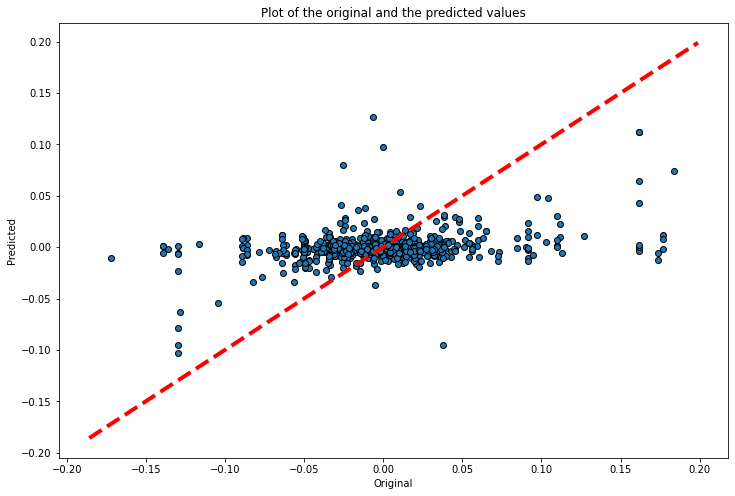

In [101]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y_test, y_gbr_cv, edgecolors=(0, 0, 0))
ax.plot([min(y), max(y)], [min(y), max(y)], 'r--', lw=4)
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
ax.set_title('Plot of the original and the predicted values')
plt.show()

***SVM Try***

In [102]:
from sklearn.svm import SVR

In [103]:
y_n = numpy_helper(tfidf_df_returns,['stock_shift'])
y_n

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y_n, test_size=0.2, train_size=0.8, random_state=123)

In [105]:
svr = SVR().fit(X_train,y_train.ravel())

In [106]:
y_svr = svr.predict(X_test)

In [107]:
r2_score(y_test,y_svr)

-0.15654248223649891

***MLPClassifier try***

In [108]:
from sklearn.neural_network import MLPClassifier

In [109]:
clf = MLPClassifier(max_iter = 800).fit(X_train, y_train.ravel())

In [110]:
y_clf = clf.predict(X_test)

In [111]:
r2_score(y_test,y_clf)

-0.4725054416313439

## **Figures for the dataStory:**

### ***1. Plot quotations per day for every year***

In [112]:
quotesperday= df_tesla.groupby(by='just_date').size().reset_index(name='Number of quotes')
quotesperday['year']= quotesperday['just_date'].apply(lambda x: x.year)
fig = px.line(quotesperday, x='just_date', y='Number of quotes',markers=True, color = 'year')
fig.update_layout(
    title={
        'text': "Number of Elon Musk's quotation per day",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        xaxis_title = 'Date')
linkhtml= plotly.io.to_html(fig)
f = open("/content/drive/MyDrive/quotesPerDay.html",'w')
f.write(linkhtml)
f.close()
fig.show()

### ***2. Compare between 2 sentiment analysis models***

In [113]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=df_sentiment.vader_sentiment_continuous,name="Vader model" ))
fig.add_trace(go.Histogram(x=df_sentiment.blob_sentiment_continuous,name="Text Blob model"))
fig.update_layout(barmode='overlay',
                  title={
                      'text': "Distribution of the polarity output of both TextBlob and Vader pretrained models",
                      'y':0.95,
                      'x':0.5,
                      'xanchor': 'center',
                      'yanchor': 'top'},
                  xaxis_title = 'Score polarity',
                  yaxis_title = 'Count')
fig.update_traces(opacity=0.7)

linkhtml= plotly.io.to_html(fig)
f = open("/content/drive/MyDrive/model_comparison.html",'w')
f.write(linkhtml)
f.close()

fig.show()

In [115]:
px.scatter(result, y = 'returns', x = 'vader_sentiment_continuous', title = 'Correlation between sentiment and the returns')

In [116]:
fig0= px.line(result, x='just_date', y='returns',range_x=['2016-01-01','2016-12-31'],markers=True )
fig0.show()

# **June 2018 quotations:**
We can notice from the plots that on June 22 there was a drastic decrease in tesla's share price, lets understand where does this comes from. 
In order to analyse what happened on june 2016 we decided to inspect the quotations said during this month. 

In [117]:
start_date = pd.to_datetime("2016-06-01").date()
end_date = pd.to_datetime("2016-06-30").date()
df_june = df_musk[(df_musk['just_date'] >= start_date)& (df_musk['just_date'] <=  end_date)]
sfmt = 'The {just_date} Elon Musk said: {quotation} '.format
test = df_june.apply(lambda x: sfmt(**x), 1)
for quote in test:
  print(quote)

The 2016-06-02 Elon Musk said: If you've got to choose a place to die, then Mars is probably not a bad choice, 
The 2016-06-01 Elon Musk said: machines that build the machines. 
The 2016-06-30 Elon Musk said: one of the safest cars on the road, 
The 2016-06-02 Elon Musk said: It' s the exciting, inspiring future that I think people want. 
The 2016-06-01 Elon Musk said: So it will still be very cheap, and far cheaper than gasoline, to drive long-distance with the Model 3. But it will not be free long distance for life unless you purchase that package. I wish we could, but in order to achieve the economics, it has to be something like that. 
The 2016-06-02 Elon Musk said: There' s no such thing as the term `escape altitude,' just `escape velocity, ' 
The 2016-06-22 Elon Musk said: Instead of making three trips to a house to put in a car charger and solar panels and battery pack, you can integrate that into a single visit, 
The 2016-06-30 Elon Musk said: Apple (NASDAQ: AAPL) 
The 2016-06-

In [119]:
start_date = pd.to_datetime("2018-09-27").date()
end_date = pd.to_datetime("2018-10-04").date()
df_june = df_tesla[(df_tesla['just_date'] >= start_date)& (df_tesla['just_date'] <=  end_date)]
sfmt = 'The {just_date} Elon Musk said: {quotation} '.format
test = df_june.apply(lambda x: sfmt(**x), 1)
for quote in test:
  print(quote)

The 2018-09-27 Elon Musk said: [ s ] ubjects Tesla to constant defamatory attacks by the short-selling community, resulting in great harm to our valuable brand. 
The 2018-09-27 Elon Musk said: Offer to Take Tesla Private at $420. 
The 2018-10-01 Elon Musk said: drive Tesla into bankruptcy even faster. 
The 2018-09-30 Elon Musk said: On August 7, 2018, Musk tweeted to his 22 million Twitter followers that he could take Tesla private at $420 per share (a substantial premium to its trading price at the time), that funding for the transaction had been secured, and that the only remaining uncertainty was a shareholder vote. The SEC's complaint alleges that, in truth, Musk had not discussed specific deal terms with any potential financing partners, and he allegedly knew that the potential transaction was uncertain and subject to numerous contingencies. According to the SEC's complaint, Musk's tweets caused Tesla's stock price to jump by over six percent on August 7, and led to significant ma

INTERACTIVE PLOTS : 2018


In [120]:
august_2018 = tesla[tesla.just_date.map(lambda x : (x.year == 2018) & ( 8 <= x.month <= 10))]
august_2018.reset_index(level=0, inplace=True)
august_2018 

,index,just_date,High,Low,Open,Close,Volume,Adj Close,returns
0,901,2018-08-01,60.599998,58.599998,59.598000,60.167999,50647000,60.167999,0.009056
1,902,2018-08-02,69.998001,64.632004,65.688004,69.907997,116075000,69.907997,0.161880
2,903,2018-08-03,71.000000,68.505997,69.561996,69.634003,68282500,69.634003,-0.003919
3,904,2018-08-06,70.996002,68.363998,69.092003,68.398003,42821500,68.398003,-0.017750
4,905,2018-08-07,77.491997,67.830002,68.767998,75.914001,154379000,75.914001,0.109886
...,...,...,...,...,...,...,...,...,...
60,961,2018-10-25,64.199997,60.202000,63.444000,62.972000,104203500,62.972000,0.091369
61,962,2018-10-26,67.980003,61.330002,61.650002,66.180000,137127500,66.180000,0.050943
62,963,2018-10-29,69.431999,65.300003,67.494003,66.970001,72430000,66.970001,0.011937
63,964,2018-10-30,67.580002,64.452003,65.678001,65.980003,45633500,65.980003,-0.014783


In [121]:


fig = px.line(august_2018, x='just_date', y='Close', markers=True)
fig.update_layout(
    title={
        'text': "Tesla stock price evolution between August and October 2018",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        yaxis_title = 'Close price in dollars')

linkhtml= plotly.io.to_html(fig)
f = open("/content/drive/MyDrive/stock_price_2018.html",'w')
f.write(linkhtml)
f.close()

fig.show()

In [122]:
fig = px.bar(august_2018, x='just_date', y="returns")
fig.update_yaxes(ticklabelposition="inside top", title='Returns')
fig.update_layout(
    title={
        'text': "Tesla returns between August and October 2018",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        yaxis_title = 'Close price in dollars')

linkhtml= plotly.io.to_html(fig)
f = open("/content/drive/MyDrive/returns_2018.html",'w')

f.write(linkhtml)
f.close()
fig.show()

INTERACTIVE PLOTS 2016

In [123]:
june_2016 = tesla[tesla.just_date.map(lambda x : (x.year == 2016) & ( x.month == 6))]
june_2016.reset_index(level=0, inplace=True)
june_2016 

,index,just_date,High,Low,Open,Close,Volume,Adj Close,returns
0,355,2016-06-01,44.480000,43.377998,44.296001,43.911999,14913500,43.911999,-0.016440
1,356,2016-06-02,43.981998,43.422001,43.917999,43.792000,10164000,43.792000,-0.002733
2,357,2016-06-03,44.388000,43.602001,44.000000,43.798000,11145000,43.798000,0.000137
3,358,2016-06-06,44.180000,43.090000,43.599998,44.136002,11247500,44.136002,0.007717
4,359,2016-06-07,46.888000,44.304001,44.448002,46.467999,31068000,46.467999,0.052837
5,360,2016-06-08,48.169998,46.521999,46.759998,47.104000,29860000,47.104000,0.013687
6,361,2016-06-09,47.066002,45.411999,46.995998,45.872002,22460500,45.872002,-0.026155
7,362,2016-06-10,45.594002,43.683998,45.478001,43.757999,30133000,43.757999,-0.046085
8,363,2016-06-13,45.153999,43.532001,43.900002,43.574001,20965000,43.574001,-0.004205
9,364,2016-06-14,44.439999,42.506001,43.776001,42.992001,17901000,42.992001,-0.013357


In [124]:
fig = px.line(june_2016, x='just_date', y='Close', markers=True)
fig.update_layout(
    title={
        'text': "Tesla stock price evolution during June 2016",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        yaxis_title = 'Close price in dollars')

linkhtml= plotly.io.to_html(fig)
f = open("/content/drive/MyDrive/stock_price_2016.html",'w')
f.write(linkhtml)
f.close()

fig.show()

In [125]:
fig = px.bar(june_2016, x='just_date', y="returns")
fig.update_yaxes(ticklabelposition="inside top", title='Returns')
fig.update_layout(
    title={
        'text': "Tesla returns during June 2016",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        yaxis_title = 'Close price in dollars')

linkhtml= plotly.io.to_html(fig)
f = open("/content/drive/MyDrive/returns_2016.html",'w')

f.write(linkhtml)
f.close()
fig.show()